In [1]:
import gpflow
import numpy as np
from math import *
import matplotlib.pyplot as plt
import sys
import random
from scipy import stats
from IPython import display
%matplotlib inline
plt.style.use('ggplot')


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
random.seed(0)
np.random.seed(0)
N = 1

dt = 0.01
gamma = 0.5
alpha = 2.0
D = 0.25
epsilon = sqrt(2*D*dt)

def potential_function(x):
    return 6*x-9.6*x**3+3.0*x**5


position = np.zeros((1,2))
speed = 2

# run for this many time steps
TIMESTEPS = 1000000
speeds = np.zeros(TIMESTEPS)
# simulate individual movement
for t in range(TIMESTEPS):
    
    speed = speed - dt*potential_function(speed) + epsilon*np.random.normal()
    position[0,0] += dt*speed
    speeds[t]=speed
    
plt.figure()
plt.plot(speeds)
plt.show()

## fit the GP
y = np.diff(speeds)/dt
y = np.expand_dims(y,-1)
x = speeds[:-1]
x = np.expand_dims(x,-1)
samples = 20000
inds = np.random.choice(x.shape[0], samples, replace=False)
#x=x[inds]
#y=y[inds]
k = gpflow.kernels.RBF(1)
#m = gpflow.models.SGPR(x, y, kern=k)
M = 20 # Inducing points
Z = x[:M, :].copy() # Inducing points
m = gpflow.models.SGPR(x, y, k, Z)
m.likelihood.variance = 1.0



gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())


# plot the fit and the original
xx = np.linspace(-2.1, 2.1, 100).reshape(100, 1)
mean, var = m.predict_y(xx)
plt.figure(figsize=(12, 6))

plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - np.sqrt(var[:,0]),
                 mean[:,0] + np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

y = np.diff(speeds)/dt


ys =  6*xx-9.6*xx**3+3.0*xx**5
plt.plot(xx, -ys, color='blue', lw=2,ls='--')

plt.xlim(-1.8, 1.8)
plt.ylim(-10, 10)

plt.show()



## 2-dimensional movement

In [ ]:
random.seed(0)
np.random.seed(0)
N = 1

dt = 0.01
gamma = 0.5
alpha = 2.0
D = 0.25
epsilon = sqrt(2*D*dt)

def potential_function(x):
    return 6-9.6*x**2+3.0*x**4


position = np.zeros((1,2))
velocity = np.zeros((1,2))

# run for this many time steps
TIMESTEPS = 1000000
speeds = np.zeros((TIMESTEPS,2))
# simulate individual movement
for t in range(TIMESTEPS):
    speed = np.linalg.norm(velocity)
    speeds[t]=velocity
    velocity = velocity - dt*velocity*potential_function(speed) + epsilon*np.random.normal(size=(1,2))
    #velocity[0,1]=0
    position += dt*velocity
    
    # plot the positions of all individuals
    #plt.clf()
    
    #plt.scatter(position[:,0], position[:,1])
    #plt.axes().set_aspect('equal')
    #plt.axis([-1,1,-1,1])
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
plt.figure()
plt.plot(np.linalg.norm(speeds,axis=-1))
plt.show()

In [ ]:

## rotate so that pointing in x-direction
y = np.diff(speeds,axis=0)/dt
#y = np.expand_dims(y[:,0],-1)
x = speeds[:-1].copy()

for i in range(len(x)):
    
    angle = np.arctan2(x[i,1],x[i,0])

    c, s = np.cos(angle), -np.sin(angle)
    R = np.array(((c,-s), (s, c)))
    
    y[i,:]=np.dot(R,y[i,:])
    x[i,:]=np.dot(R,x[i,:])
print(y.shape)
plt.figure()
plt.hist(angles)
plt.show()

plt.figure()
plt.plot(y[:,0],y[:,1],'.')
plt.axis('equal')
plt.show()

In [ ]:

## fit the GP
k = gpflow.kernels.RBF(input_dim=2)

M = 20 # Inducing points
Z = x[:M, :].copy() # Inducing points
m = gpflow.models.SGPR(x, y, k, Z)
#m.likelihood.variance = 1.0



gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

In [ ]:


# plot the fit and the original
xx = np.linspace(-2, 2, 100).reshape(100, 1)
yy = np.zeros_like(xx)
#xx, yy = np.mgrid[-2.1:2.1:1, -2.1:2.1:100]
#xx2d = np.vstack([xx.ravel(), yy.ravel()])
xx2d = np.hstack([xx,yy])
mean, var = m.predict_y(xx2d)

#mean, var = m.predict_y(xx)
plt.figure(figsize=(12, 6))

plt.plot(xx, mean[:,0], 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - np.sqrt(var[:,1]),
                 mean[:,0] + np.sqrt(var[:,1]),
                 color='C0', alpha=0.2)

y = np.diff(speeds)/dt


ys =  6*xx-9.6*xx**3+3.0*xx**5
plt.plot(xx, -ys, color='blue', lw=2,ls='--')

plt.xlim(-1.8, 1.8)
plt.ylim(-10, 10)

plt.show()

In [ ]:
y.shape

In [ ]:

# plot the fit and the original
xx1 = np.linspace(-1.1, 1.1, 1000).reshape(1000, 1)
xx2 = np.linspace(-1.1, 1.1, 1000).reshape(1000, 1)

np.meshgrid(xx1, xx2)

xx, yy = np.mgrid[-2:2:1000j, -2:2:1000j]
xx2d = np.vstack([xx.ravel(), yy.ravel()])
mean, var = m.predict_y(xx2d.T)

speedgrid=mean[:,0]#/xx2d[0]#np.linalg.norm(mean,axis=-1)
speedgrid = np.reshape(speedgrid,(1000,1000))
plt.imshow(speedgrid,vmin=-5,vmax=5)
plt.show()

speedgrid=mean[:,1]#/xx2d[0]#np.linalg.norm(mean,axis=-1)
speedgrid = np.reshape(speedgrid,(1000,1000))
plt.imshow(speedgrid,vmin=-5,vmax=5)
plt.show()
#plt.plot(xx, mean, 'C0', lw=2)
#plt.fill_between(xx[:,0],
#                 mean[:,0] - np.sqrt(var[:,0]),
#                 mean[:,0] + np.sqrt(var[:,0]),
#                 color='C0', alpha=0.2)



## Now with interactions!

In [ ]:

# Force-based interaction model

import numpy as np
from math import *
import matplotlib.pyplot as plt
import sys
import random

N = 2

dt = 0.01
gamma = 0.5
alpha = 2.0
D = 0.25
epsilon = sqrt(2*D*dt)

def potential_function(x):
    return 6-9.6*x**2+3.0*x**4


positions = np.zeros((N,2))
velocity = np.zeros((N,2))

def social_forces(j):
    forces = np.zeros((1,2))
    dx = positions[0,0]-positions[1,0]
    dy = positions[0,1]-positions[1,1]
    dist = sqrt(dx**2+dy**2)
    
    if dist==0:
        return forces
    if j==0:
        if dist<0.25:
            forces[0,0]=10*dx/dist
            forces[0,1]=10*dy/dist
    if j==1:
        if dist>0.5:
    #print('attract')
            forces[0,0]=10*dx/dist
            forces[0,1]=10*dy/dist
    #print(forces)
    return forces    
    
# run for this many time steps
TIMESTEPS = 1000000
speeds = np.zeros((TIMESTEPS,N,2))
pos = np.zeros((TIMESTEPS,N,2))
# simulate individual movement
for t in range(TIMESTEPS):
    for j in range(N):
        speed = np.linalg.norm(velocity[j])
        speeds[t,j]=velocity[j]
        pos[t,j]=positions[j]
        velocity[j] = velocity[j] - dt*velocity[j]*potential_function(speed) + dt * social_forces(j) +  epsilon*np.random.normal(size=(1,2))
        #velocity[0,1]=0
        positions[j] += dt*velocity[j]
# # plot the positions of all individuals
#     plt.clf()
#     velx = np.divide(velocity[:,0],(np.linalg.norm(velocity,axis=1)))
#     vely = np.divide(velocity[:,1],(np.linalg.norm(velocity,axis=1)))
#     plt.quiver(positions[:,0], positions[:,1],velx, vely)
#     plt.axes().set_aspect('equal')
#     plt.axis([-5,5,-5,5])
#     #plt.draw()
#     #plt.pause(0.001)

#     # plot the positions of all individuals

#     display.display(plt.gcf())
#     display.clear_output(wait=True)


In [ ]:
plt.plot(pos[:,0,0],pos[:,0,1])
plt.plot(pos[:,1,0],pos[:,1,1])

In [ ]:
#y = np.diff(speeds[:,0,:],axis=0)/dt
y.shape

In [ ]:


## rotate so that pointing in x-direction
y = np.diff(speeds[:,1,:],axis=0)/dt
#y = np.expand_dims(y[:,0],-1)
x1 = speeds[:-1,1,:].copy()
x2 = (pos[:-1,0,:]-pos[:-1,1,:])
for i in range(len(x1)):
    
    angle = np.arctan2(x1[i,1],x1[i,0])

    c, s = np.cos(angle), -np.sin(angle)
    R = np.array(((c,-s), (s, c)))
    
    y[i,:]=np.dot(R,y[i,:])
    x1[i,:]=np.dot(R,x1[i,:])
    x2[i,:]=np.dot(R,x2[i,:])

x = np.hstack((x1,x2))
plt.figure()
plt.plot(y[:,0],y[:,1],'.')
plt.axis('equal')
plt.show()

In [ ]:

## fit the GP
k1 = gpflow.kernels.RBF(input_dim=2, active_dims=[0,1], ARD=False)
k2 = gpflow.kernels.RBF(input_dim=2, active_dims=[2,3], ARD=False)
k=k1+k2
M = 20 # Inducing points
Z = x[:M, :].copy() # Inducing points
m = gpflow.models.SGPR(x, y, k, Z)
#m.likelihood.variance = 1.0



gpflow.train.ScipyOptimizer().minimize(m)
print(m.as_pandas_table())

# Plotting the interactions of the repulsed individual

In [ ]:
k3 = gpflow.kernels.RBF(input_dim=2, active_dims=[2,3], ARD=False,lengthscales=m.kern.kernels[1].lengthscales.value, variance=m.kern.kernels[1].variance.value)


m1 = gpflow.models.SGPR(x, y, k3, Z)
#m1 = GPflow.svgp.SVGP(X, Y, Z = m.Z.value, kern=k1, likelihood=lik)
#m2 = GPflow.svgp.SVGP(X, Y, Z = m.Z.value, kern=k2, likelihood=lik)
m1.likelihood.variance = m.likelihood.variance


xr = 0.5
xx, yy = np.mgrid[-xr:xr:1000j, -xr:xr:1000j]
xx = xx.ravel()
yy = yy.ravel()
zz = np.zeros_like(xx)
xx2d = np.hstack((np.expand_dims(zz,-1),np.expand_dims(zz,-1),np.expand_dims(xx,-1),np.expand_dims(yy,-1)))
mean, var = m.predict_y(xx2d)


normx = -xx/((xx**2+yy**2)**0.5)
normy = -yy/((xx**2+yy**2)**0.5)

#speedgrid=np.linalg.norm(mean,axis=-1)

speedgrid = mean[:,0]*normx+mean[:,1]*normy
speedgrid = np.reshape(speedgrid,(1000,1000))

plt.imshow(speedgrid.T,extent=[-xr,xr,-xr,xr])
plt.colorbar()
plt.show()


# Interactions of the follower

In [ ]:
k3 = gpflow.kernels.RBF(input_dim=2, active_dims=[2,3], ARD=False,lengthscales=m.kern.kernels[1].lengthscales.value, variance=m.kern.kernels[1].variance.value)


m1 = gpflow.models.SGPR(x, y, k3, Z)
#m1 = GPflow.svgp.SVGP(X, Y, Z = m.Z.value, kern=k1, likelihood=lik)
#m2 = GPflow.svgp.SVGP(X, Y, Z = m.Z.value, kern=k2, likelihood=lik)
m1.likelihood.variance = m.likelihood.variance


xr = 1.0
xx, yy = np.mgrid[-xr:xr:1000j, -xr:xr:1000j]
xx = xx.ravel()
yy = yy.ravel()
zz = np.zeros_like(xx)
xx2d = np.hstack((np.expand_dims(zz,-1),np.expand_dims(zz,-1),np.expand_dims(xx,-1),np.expand_dims(yy,-1)))
mean, var = m.predict_y(xx2d)


normx = -xx/((xx**2+yy**2)**0.5)
normy = -yy/((xx**2+yy**2)**0.5)

#speedgrid=np.linalg.norm(mean,axis=-1)

speedgrid = mean[:,0]*normx+mean[:,1]*normy
speedgrid = np.reshape(speedgrid,(1000,1000))

plt.imshow(speedgrid.T,extent=[-xr,xr,-xr,xr])
plt.colorbar()
plt.show()

In [ ]:

k3 = gpflow.kernels.RBF(input_dim=2, active_dims=[0,1], ARD=False,lengthscales=m.kern.kernels[0].lengthscales.value, variance=m.kern.kernels[0].variance.value)


m1 = gpflow.models.SGPR(x, y, k3, Z)
#m1 = GPflow.svgp.SVGP(X, Y, Z = m.Z.value, kern=k1, likelihood=lik)
#m2 = GPflow.svgp.SVGP(X, Y, Z = m.Z.value, kern=k2, likelihood=lik)
m1.likelihood.variance = m.likelihood.variance

# plot the fit and the original
xx = np.linspace(-2, 2, 100).reshape(100, 1)
yy = np.zeros_like(xx)
zz = 100*np.ones_like(xx)
#xx, yy = np.mgrid[-2.1:2.1:1, -2.1:2.1:100]
#xx2d = np.vstack([xx.ravel(), yy.ravel()])
xx2d = np.hstack([xx,yy,zz,zz])
mean, var = m.predict_y(xx2d)

#mean, var = m.predict_y(xx)
plt.figure(figsize=(12, 6))

plt.plot(xx, mean[:,0], 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - np.sqrt(var[:,1]),
                 mean[:,0] + np.sqrt(var[:,1]),
                 color='C0', alpha=0.2)

y = np.diff(speeds)/dt


ys =  6*xx-9.6*xx**3+3.0*xx**5
plt.plot(xx, -ys, color='blue', lw=2,ls='--')

plt.xlim(-1.8, 1.8)
plt.ylim(-10, 10)

plt.show()




# Zonal interaction model

In [2]:

# Force-based interaction model

import numpy as np
from math import *
import matplotlib.pyplot as plt
import sys
import random

N = 5

dt = 0.01
gamma = 0.5
alpha = 2.0
D = 0.25
epsilon = sqrt(2*D*dt)
repulse = 0.25
attract = 2.5
def potential_function(x):
    return 6-9.6*x**2+3.0*x**4


positions = np.zeros((N,2))
velocity = np.zeros((N,2))

def social_forces(j):
    forces = np.zeros((1,2))
    repulsion = []
    attraction = []

    # calculate distances to all neighbours
    xdiffs = positions[:,0] - positions[j,0]
    ydiffs = positions[:,1] - positions[j,1]
    
    dists = np.sqrt(xdiffs**2+ydiffs**2)
   
    # loop over all neighbours and store index of individuals within each range
    for i in range(N):
        if i != j:
            dist = dists[i]
            if dist <= repulse:
                repulsion.append(i)
            elif dist <= attract:
                attraction.append(i)

    if repulsion:
        #code for repulsion interaction here
        for k in repulsion:
            if dists[k]==0: continue
            forces[0,0]-=10*xdiffs[k]/dists[k]
            forces[0,1]-=10*ydiffs[k]/dists[k]
            
            
    elif attraction:
        #code for attraction interaction here
        for k in attraction:
            if dists[k]==0: continue
            forces[0,0]+=5*xdiffs[k]/dists[k]
            forces[0,1]+=5*ydiffs[k]/dists[k]
        
    if np.any(np.isnan(forces)):  
        forces = np.zeros((1,2))
    return forces
    
# run for this many time steps
TIMESTEPS = 100000
speeds = np.zeros((TIMESTEPS,N,2))
pos = np.zeros((TIMESTEPS,N,2))
# simulate individual movement
for t in range(TIMESTEPS):
    for j in range(N):
        speed = np.linalg.norm(velocity[j])
        speeds[t,j]=velocity[j]
        pos[t,j]=positions[j]
        velocity[j] = velocity[j] - dt*velocity[j]*potential_function(speed) + dt * social_forces(j) +  epsilon*np.random.normal(size=(1,2))
        #velocity[0,1]=0
        positions[j] += dt*velocity[j]
# plot the positions of all individuals
#     if t%10!=0:
#         continue
#     plt.clf()
#     velx = np.divide(velocity[:,0],(np.linalg.norm(velocity,axis=1)))
#     vely = np.divide(velocity[:,1],(np.linalg.norm(velocity,axis=1)))
#     plt.quiver(positions[:,0], positions[:,1],velx, vely)
#     plt.axes().set_aspect('equal')
#     plt.axis([-20,20,-20,20])
#     # plot the positions of all individuals

#     display.display(plt.gcf())
#     display.clear_output(wait=True)


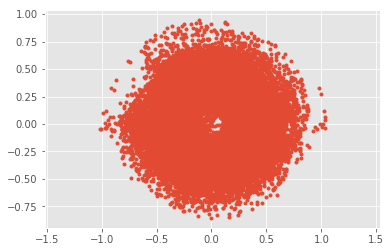

In [17]:


## rotate so that pointing in x-direction
y = np.diff(speeds[:,0,:],axis=0)/dt
#y = np.expand_dims(y[:,0],-1)
x1 = speeds[:-1,0,:].copy()
x2 = (pos[:-1,1,:]-pos[:-1,0,:])
x3 = (pos[:-1,2,:]-pos[:-1,0,:])
x4 = (pos[:-1,3,:]-pos[:-1,0,:])
x5 = (pos[:-1,4,:]-pos[:-1,0,:])

for i in range(len(x1)):
    
    angle = np.arctan2(x1[i,1],x1[i,0])

    c, s = np.cos(angle), -np.sin(angle)
    R = np.array(((c,-s), (s, c)))
    
    y[i,:]=np.dot(R,y[i,:])
    x1[i,:]=np.dot(R,x1[i,:])
    x2[i,:]=np.dot(R,x2[i,:])
    x3[i,:]=np.dot(R,x3[i,:])
    x4[i,:]=np.dot(R,x4[i,:])
    x5[i,:]=np.dot(R,x5[i,:])
    
#xa = np.vstack((x2,x3,x4,x5))

#x2=x2/np.std(xa)
#x3=x3/np.std(xa)
#x4=x4/np.std(xa)
#x5=x5/np.std(xa)

x = np.hstack((x1,x2,x3,x4,x5))
plt.figure()
plt.plot(x5[:,0],x5[:,1],'.')
plt.axis('equal')
plt.show()

In [13]:
xa = np.vstack((x2,x3,x4,x5))
xa.shape
x2=x2/np.std(xa)
x3=x3/np.std(xa)
x4=x4/np.std(xa)
x5=x5/np.std(xa)

xa = np.vstack((x2,x3,x4,x5))

np.std(xa)

1.0000000000000002

In [4]:

import tensorflow as tf
from functools import reduce
from gpflow.params import Parameter, Parameterized, ParamList
from gpflow.decors import params_as_tensors, autoflow
from gpflow import transforms
from gpflow import settings

class socialRBF(gpflow.kernels.Kernel):
    """
    Base class for kernels that are stationary, that is, they only depend on
        r = || x - x' ||
    This class handles 'ARD' behaviour, which stands for 'Automatic Relevance
    Determination'. This means that the kernel has one lengthscale per
    dimension, otherwise the kernel is isotropic (has a single lengthscale).
    """

    def __init__(self, input_dim, variance=1.0, lengthscales=1.0,
                 active_dims=None, ARD=None, name=None):
        """
        - input_dim is the dimension of the input to the kernel
        - variance is the (initial) value for the variance parameter
        - lengthscales is the initial value for the lengthscales parameter
          defaults to 1.0 (ARD=False) or np.ones(input_dim) (ARD=True).
        - active_dims is a list of length input_dim which controls which
          columns of X are used.
        - if ARD is not None, it specifies whether the kernel has one
          lengthscale per dimension (ARD=True) or a single lengthscale
          (ARD=False). Otherwise, inferred from shape of lengthscales.
        """
        super().__init__(input_dim, active_dims, name=name)
        self.variance = Parameter(variance, transform=transforms.positive,
                                  dtype=settings.float_type)#,trainable=False)
        self.nscale = Parameter(4.0, transform=transforms.positive,
                                  dtype=settings.float_type,trainable=False)

        lengthscales, self.ARD = self._validate_ard_shape("lengthscales", lengthscales, ARD)
        self.lengthscales = Parameter(lengthscales, transform=transforms.positive,
                                      dtype=settings.float_type)


    


    @params_as_tensors
    def scaled_square_dist(self, X, X2):
        """
        Returns ((X - X2ᵀ)/lengthscales)².
        Due to the implementation and floating-point imprecision, the
        result may actually be very slightly negative for entries very
        close to each other.
        """
        X = X / self.lengthscales
        Xs = tf.reduce_sum(tf.square(X), axis=1)

        if X2 is None:
            dist = -2 * tf.matmul(X, X, transpose_b=True)
            dist += tf.reshape(Xs, (-1, 1))  + tf.reshape(Xs, (1, -1))
            return dist

        X2 = X2 / self.lengthscales
        X2s = tf.reduce_sum(tf.square(X2), axis=1)
        dist = -2 * tf.matmul(X, X2, transpose_b=True)
        dist += tf.reshape(Xs, (-1, 1)) + tf.reshape(X2s, (1, -1))
        return dist


   


    @params_as_tensors
    def Kdiag(self, X, presliced=False):
        print('hello')
        return tf.fill(tf.stack([tf.shape(X)[0]]), tf.squeeze(self.nscale*self.variance))

    """
    The radial basis function (RBF) or squared exponential kernel
    """

    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        
        #print(self.variance)
        
        X2_N1=None
        X2_N2=None
        X2_N3=None
        X2_N4=None
        X_N1 = tf.transpose(tf.gather(tf.transpose(X), self.active_dims[0:2]))
        if X2 is not None:
            X2_N1 = tf.transpose(tf.gather(tf.transpose(X2), self.active_dims[0:2]))
        
        X_N1 = tf.identity(X_N1)

        X_N2 = tf.transpose(tf.gather(tf.transpose(X), self.active_dims[2:4]))
        if X2 is not None:
            X2_N2 = tf.transpose(tf.gather(tf.transpose(X2), self.active_dims[2:4]))
            
        X_N2 = tf.identity(X_N2)

        X_N3 = tf.transpose(tf.gather(tf.transpose(X), self.active_dims[4:6]))
        if X2 is not None:
            X2_N3 = tf.transpose(tf.gather(tf.transpose(X2), self.active_dims[4:6]))
        
        X_N3 = tf.identity(X_N3)
        
        X_N4 = tf.transpose(tf.gather(tf.transpose(X), self.active_dims[6:8]))
        if X2 is not None:
            X2_N4 = tf.transpose(tf.gather(tf.transpose(X2), self.active_dims[6:8]))
        X_N4 = tf.identity(X_N4)
        #return  reduce(tf.add, [tf.exp(-self.scaled_square_dist(X_N1, X2_N1) / 2), tf.exp(-self.scaled_square_dist(X_N2, X2_N2) / 2 ), tf.exp(-self.scaled_square_dist(X_N3, X2_N3) / 2) , tf.exp(-self.scaled_square_dist(X_N4, X2_N4) / 2 ) ])     
        return  reduce(tf.add, [self.variance*tf.exp(-self.scaled_square_dist(X_N1, X2_N1) / 2), self.variance*tf.exp(-self.scaled_square_dist(X_N2, X2_N2) / 2 ), self.variance*tf.exp(-self.scaled_square_dist(X_N3, X2_N3) / 2) , self.variance*tf.exp(-self.scaled_square_dist(X_N4, X2_N4) / 2 ) ])     
        #return self.variance * (tf.exp(-self.scaled_square_dist(X_N1, X2_N1) / 2) )
                                    #+ tf.exp(-self.scaled_square_dist(X_N2, X2_N2) / 2) 
                                    #+ tf.exp(-self.scaled_square_dist(X_N3, X2_N3) / 2) 
                                    #+ tf.exp(-self.scaled_square_dist(X_N4, X2_N4) / 2) )        

In [8]:

## fit the GP
k1 = gpflow.kernels.RBF(input_dim=2, active_dims=[0,1], ARD=False)
k2 = socialRBF(input_dim=8, active_dims=[2,3,4,5,6,7,8,9], ARD=False,variance=1.0)
#k2 = gpflow.kernels.RBF(input_dim=2, active_dims=[2,3], ARD=False)
#k3 = gpflow.kernels.RBF(input_dim=2, active_dims=[4,5], ARD=False)
#k4 = gpflow.kernels.RBF(input_dim=2, active_dims=[6,7], ARD=False)
#k5 = gpflow.kernels.RBF(input_dim=2, active_dims=[8,9], ARD=False)

k=k1+k2#+k3+k4+k5
M = 20 # Inducing points
Z = x[:M, :].copy() # Inducing points
m = gpflow.models.SGPR(x, y, k, Z)
#m.likelihood.variance = 1.0


#gpflow.train.
#o = gpflow.train.ScipyOptimizer(method='BFGS',options={'gtol': 1e-6, 'disp': True})
gpflow.train.ScipyOptimizer().minimize(m)#,disp=True)
print(m.as_pandas_table())

hello
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 766579.698605
  Number of iterations: 1000
  Number of functions evaluations: 1064
                                      class prior transform  trainable  \
SGPR/kern/kernels/0/variance      Parameter  None       +ve       True   
SGPR/kern/kernels/0/lengthscales  Parameter  None       +ve       True   
SGPR/kern/kernels/1/variance      Parameter  None       +ve       True   
SGPR/kern/kernels/1/nscale        Parameter  None       +ve      False   
SGPR/kern/kernels/1/lengthscales  Parameter  None       +ve       True   
SGPR/likelihood/variance          Parameter  None       +ve       True   
SGPR/feature/Z                    Parameter  None    (none)       True   

                                     shape  fixed_shape  \
SGPR/kern/kernels/0/variance            ()         True   
SGPR/kern/kernels/0/lengthscales        ()         True   
SGPR/kern

In [ ]:

xx = np.linspace(-10, 10, 100).reshape(10, 10)

k2.compute_K_symm(xx)


In [ ]:

xx = np.linspace(-10, 10, 100).reshape(10, 10)

yyx = k2.compute_K_symm(xx)
print((yyx.dtype))


In [30]:
x.shape

(99999, 10)

In [ ]:
k3 = gpflow.kernels.RBF(input_dim=2, active_dims=[0,1],ARD=False,lengthscales=m.kern.kernels[1].lengthscales.value, variance=m.kern.kernels[1].variance.value)

xa = np.vstack((x2,x3,x4,x5))
ya = np.vstack((y,y,y,y))

m1 = gpflow.models.GPR(xa[::10], ya[::10], k3)#=m.Z.value)
#m1 = GPflow.svgp.SVGP(X, Y, Z = m.Z.value, kern=k1, likelihood=lik)
#m2 = GPflow.svgp.SVGP(X, Y, Z = m.Z.value, kern=k2, likelihood=lik)
m1.likelihood.variance = m.likelihood.variance


xr = 5.0
xx, yy = np.mgrid[-xr:xr:100j, -xr:xr:100j]
xx = xx.ravel()
yy = yy.ravel()
zz = 100*np.zeros_like(xx)
#xx, yy = np.mgrid[-2.1:2.1:1, -2.1:2.1:100]
#xx2d = np.vstack([xx.ravel(), yy.ravel()])
#xx2d = np.hstack([zz, zz,xx,yy])

#xx2d = np.hstack((np.expand_dims(zz,-1),np.expand_dims(zz,-1),np.expand_dims(xx,-1),np.expand_dims(yy,-1)))
xx2d = np.hstack((np.expand_dims(xx,-1),np.expand_dims(yy,-1)))
mean, var = m1.predict_y(xx2d)


normx = xx/((xx**2+yy**2)**0.5)
normy = yy/((xx**2+yy**2)**0.5)

#speedgrid=np.linalg.norm(mean,axis=-1)

speedgrid = mean[:,0]*normx+mean[:,1]*normy

speedgrid = np.reshape(speedgrid,(100,100))
fig, ax = plt.subplots(1)

plt.imshow(speedgrid.T,extent=[-xr,xr,-xr,xr])#vmax=10)
plt.colorbar()
from matplotlib.patches import Circle
circ = Circle((0,0),2.5,facecolor='None',lw=2,edgecolor='red')
ax.add_patch(circ)
circ = Circle((0,0),0.25,facecolor='None',lw=2,edgecolor='blue')
ax.add_patch(circ)
plt.show()

/usr/local/lib/python3.6/dist-packages/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


In [ ]:
plt.

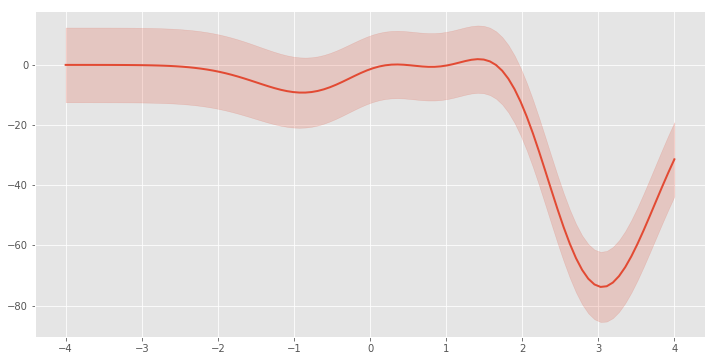

In [22]:
k3 = gpflow.kernels.RBF(input_dim=2, active_dims=[2,3], ARD=False,lengthscales=m.kern.kernels[1].lengthscales.value, variance=m.kern.kernels[1].variance.value)


m1 = gpflow.models.SGPR(x, y, k3, Z)
#m1 = GPflow.svgp.SVGP(X, Y, Z = m.Z.value, kern=k1, likelihood=lik)
#m2 = GPflow.svgp.SVGP(X, Y, Z = m.Z.value, kern=k2, likelihood=lik)
m1.likelihood.variance = m.likelihood.variance

xx = np.linspace(-4, 4, 100).reshape(100, 1)
yy = np.zeros_like(xx)
zz = 100*np.ones_like(xx)
#xx, yy = np.mgrid[-2.1:2.1:1, -2.1:2.1:100]
#xx2d = np.vstack([xx.ravel(), yy.ravel()])
xx2d = np.hstack([zz, zz,xx,yy])
mean, var = m1.predict_y(xx2d)

#mean, var = m.predict_y(xx)
plt.figure(figsize=(12, 6))

plt.plot(xx, mean[:,0], 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - np.sqrt(var[:,1]),
                 mean[:,0] + np.sqrt(var[:,1]),
                 color='C0', alpha=0.2)

plt.show()

In [ ]:
x.shape

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

In [ ]:
import tensorflow as tf
with tf.device('/cpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())